In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-01-08 16:00:41.192563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 16:00:41.192614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 16:00:41.194826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 16:00:41.207874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 16:00:43.155971: W tensorflow/compiler/tf2

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 5

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1114 (4.35 KB)
Trainable params: 1114 (4.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
21/32 [==================>...........] - ETA: 0s - loss: 1.4270 - accuracy: 0.2861 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 1s 12ms/step - loss: 1.4104 - accuracy: 0.2951 - val_loss: 1.3184 - val_accuracy: 0.5225
Epoch 2/1000
23/32 [====================>.........] - ETA: 0s - loss: 1.3479 - accuracy: 0.3645
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5


/tmp/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 0s 5ms/step - loss: 1.3447 - accuracy: 0.3694 - val_loss: 1.2710 - val_accuracy: 0.5646
Epoch 3/1000
27/32 [========================>.....] - ETA: 0s - loss: 1.2897 - accuracy: 0.4227
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 0s 8ms/step - loss: 1.2887 - accuracy: 0.4248 - val_loss: 1.1970 - val_accuracy: 0.5934
Epoch 4/1000
31/32 [============================>.] - ETA: 0s - loss: 1.2338 - accuracy: 0.4594
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 0s 6ms/step - loss: 1.2334 - accuracy: 0.4590 - val_loss: 1.1107 - val_accuracy: 0.5911
Epoch 5/1000
20/32 [=================>............] - ETA: 0s - loss: 1.1994 - accuracy: 0.4723
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 0s 6ms/step - loss: 1.1920 - accuracy: 0.4728 - val_loss

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 2ms/step - loss: 0.2667 - accuracy: 0.9653


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 102ms/step
[0.0939476  0.02317493 0.0080833  0.8747942 ]
3


# 混同行列

43/43 [==============================] - 0s 2ms/step


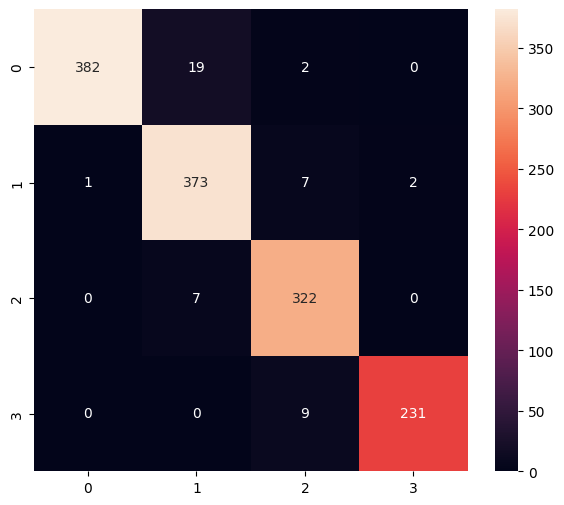

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       403
           1       0.93      0.97      0.95       383
           2       0.95      0.98      0.96       329
           3       0.99      0.96      0.98       240

    accuracy                           0.97      1355
   macro avg       0.97      0.97      0.97      1355
weighted avg       0.97      0.97      0.97      1355



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [18]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/tmp/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_3.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp6l7x6k4s/assets


INFO:tensorflow:Assets written to: /tmp/tmp6l7x6k4s/assets
2024-01-08 16:04:23.964820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-08 16:04:23.964852: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-08 16:04:23.965243: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6l7x6k4s
2024-01-08 16:04:23.966832: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-08 16:04:23.966847: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6l7x6k4s
2024-01-08 16:04:23.969766: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-08 16:04:23.970817: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-08 16:04:24.018801: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

6544

# 推論テスト

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [21]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 485 µs, sys: 47 µs, total: 532 µs
Wall time: 455 µs


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.09394757 0.02317491 0.0080833  0.8747942 ]
3
